In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import re
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.linear_model import LinearRegression

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_field_metrics
import configs

device = 'cpu'

# Collect metrics over datasets
You will have to run the corresponding python file to this jupyter notebook (will have the same title, but with 'parfor' attached).

In [78]:
gamma = 0.75
model = 'rnn'

In [ ]:
with open(f'./pickles/5a_{model}_results_gamma{gamma}.p', 'rb') as f:
    results = pickle.load(f)

In [79]:
with open(f'/home/chingf/engram/Ching/03_td_discrete_corr/5a_{model}_results_gamma{gamma}.p', 'rb') as f:
    results = pickle.load(f)

In [80]:
results.keys()

dict_keys(['gamma', 'arena_length', 'init_sparsities', 'sigmas', 'final_sparsities', 'fieldsizes', 'nfields', 'onefields', 'zerofields', 'fieldsizekls', 'nfieldkls'])

In [81]:
arena_length = np.array(results['arena_length'])
init_sparsities = np.array(results['init_sparsities'])
sigmas = np.array(results['sigmas'])
final_sparsities = np.array(results['final_sparsities'])
final_sparsities = np.around(final_sparsities, decimals=2)
fieldsizes = np.array(results['fieldsizes'])
nfields = np.array(results['nfields'])
onefields = np.array(results['onefields'])
zerofields = np.array(results['zerofields'])
fieldsizekls = np.array(results['fieldsizekls'])
nfieldkls = np.array(results['nfieldkls'])

In [82]:
df = pd.DataFrame({
    'Seed Sparsity': init_sparsities,
    'Spatial Corr.': sigmas,
    'Sparsity': final_sparsities,
    'Field Size': fieldsizes,
    'Fields per Neuron': nfields,
    'Single Field Neurons': onefields,
    'Zero Field Neurons': zerofields,
    'Field Sizes KL': fieldsizekls,
    'N Fields KL': nfieldkls
    })

# Make gradient plots

In [88]:
def make_gradients(
    xs, ys, zs, cmap="Reds", interpolate=False,
    title=None, xlabel=None, ylabel=None, figname=None,
    smooth=False, contourz=None
    ):
    
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dx = x_list[1:] - x_list[:-1]
    dy = y_list[1:] - y_list[:-1]
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            idx = np.logical_and(
                xs==x[i,j], ys==y[i,j]
                )
            z[i,j] = np.nanmean(zs[idx])

    levels = MaxNLocator(nbins=20).tick_values(np.nanmin(z), np.nanmax(z))
    fig, ax = plt.subplots()
    im = ax.pcolormesh(x, y, z, cmap=cmap)
    fig.colorbar(im, ax=ax)
    ax.set_title('pcolormesh with levels')
    plt.show()
            
    if interpolate:
        nan_mask = np.isnan(z)
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals
        
    if smooth:
        from scipy.ndimage.filters import gaussian_filter
        z = gaussian_filter(z, 1.)
        
    #levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    
    # contours are *point* based plots, so convert our bound into point
    # centers
    fig, ax = plt.subplots()
    cf = ax.contourf(x,#[:-1, :-1] + dx/2.,
                     y,#[:-1, :-1] + dy/2.,
                     z, levels=levels, cmap=cmap
                     )
    if contourz is not None:
        cntrs = plt.contour(x, y, contourz, [0.1, 0.2, 0.3], colors='dimgray')
        plt.clabel(cntrs, inline=True, fontsize=8)
    fig.colorbar(cf, ax=ax)
    ax.set_title('contourf with levels')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(f'{figname}.png', dpi=300)
    plt.show()
    
    return x, y, z

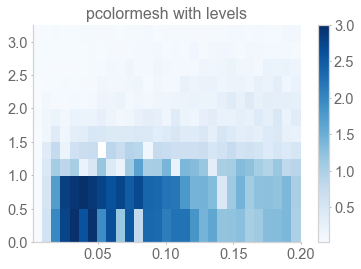

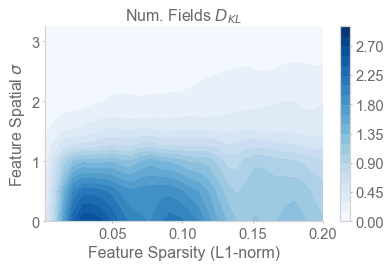

In [89]:
_x, _y, _z = make_gradients(
    init_sparsities, sigmas,
    np.clip(nfieldkls, 0, 3),
    cmap='Blues',
    title='Num. Fields $D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_nfieldkls_gamma{gamma}',
    interpolate=True, smooth=True
    )

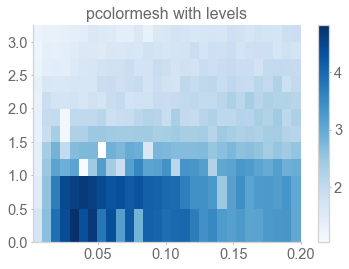

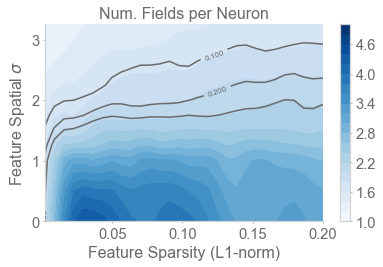

In [90]:
_, _, _ = make_gradients(
    init_sparsities, sigmas, nfields, cmap='Blues',
    title='Num. Fields per Neuron',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_nfields_gamma{gamma}',
    interpolate=True, smooth=True, contourz=_z
    )

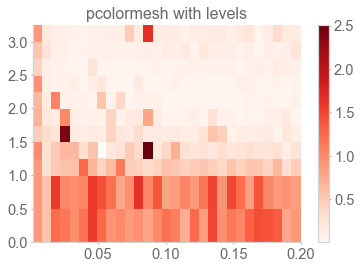

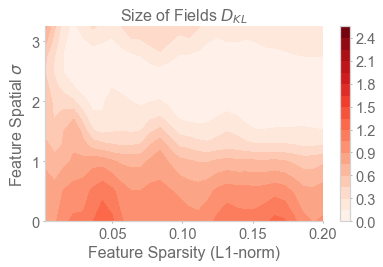

In [91]:
_x, _y, _z = make_gradients(
    init_sparsities, sigmas,
    np.clip(fieldsizekls, 0, 3),
    cmap='Reds',
    title='Size of Fields $D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_fieldsizekls_gamma{gamma}',
    interpolate=True, smooth=True
    )

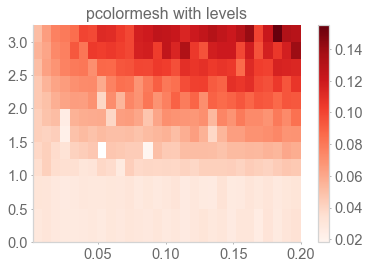

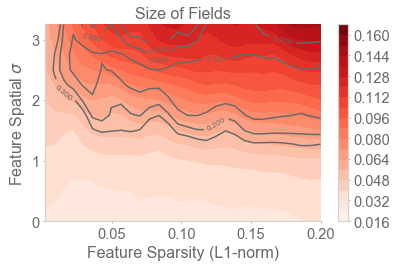

In [92]:
_,_,_ = make_gradients(
    init_sparsities, sigmas, fieldsizes, cmap='Reds',
    title='Size of Fields',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_fieldsizes_gamma{gamma}',
    interpolate=True, smooth=True, contourz=_z
    )

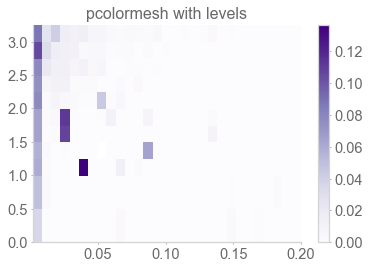

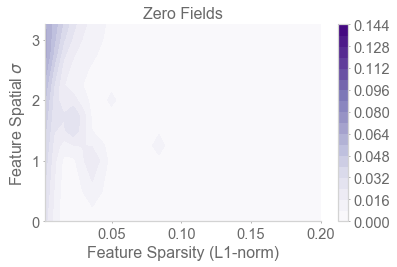

In [93]:
_, _, _ = make_gradients(
    init_sparsities, sigmas, zerofields, cmap='Purples',
    title='Zero Fields',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_zerofields_gamma{gamma}',
    interpolate=True, smooth=True
    )

# Make dataset divergence gradient plots

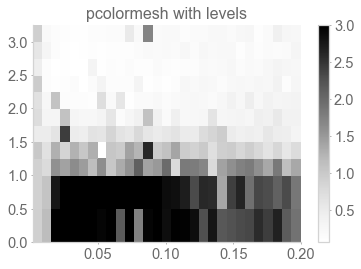

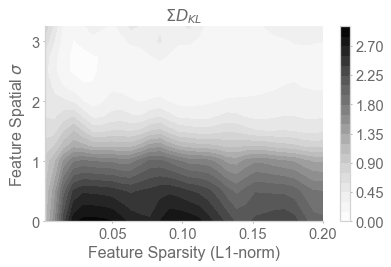

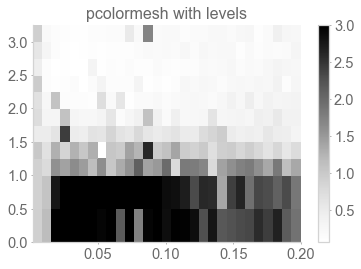

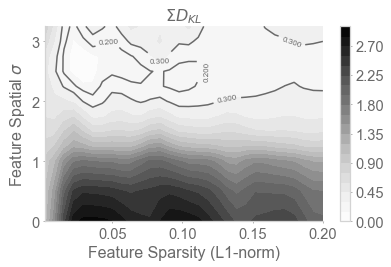

In [94]:
aggregate_kls = fieldsizekls + nfieldkls
_,_, _z = make_gradients(
    init_sparsities, sigmas,
    np.clip(aggregate_kls, 0, 3),
    cmap='Greys',
    title='$\Sigma D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_sumkls_gamma{gamma}',
    interpolate=True, smooth=True
    )
_,_, _z = make_gradients(
    init_sparsities, sigmas,
    np.clip(aggregate_kls, 0, 3),
    cmap='Greys',
    title='$\Sigma D_{KL}$',
    xlabel='Feature Sparsity (L1-norm)',
    ylabel='Feature Spatial $\sigma$',
    figname=f'5a_sumkls_gamma{gamma}',
    interpolate=True, smooth=True, contourz=_z
    )